### Imports ###

In [2]:
!pip install pandas
!pip install scikit-learn
!pip install shap
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("Social_Media_Advertising.csv")

c:\Users\Harsha\Documents\CODE\Social_Media_Advertising\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating Column Day_Duration ###

This new column will be created for turning duration strings into integers

In [4]:
df["Duration_Days"] = df["Duration"].str.extract("(\\d+)").astype(int)
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days'],
      dtype='object')

In [5]:
df["Duration_Days"].head()

0    15
1    15
2    15
3    15
4    15
Name: Duration_Days, dtype: int64

### Creating Column Acquisition_Cost_Num ###

This new column will be created for turning Acquisiton strings into floats

In [6]:
df["Acquisition_Cost_Num"] = df["Acquisition_Cost"].replace("[$,]", "", regex=True).astype(float)
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days',
       'Acquisition_Cost_Num'],
      dtype='object')

In [7]:
df["Acquisition_Cost_Num"].head()

0    500.0
1    500.0
2    500.0
3    500.0
4    500.0
Name: Acquisition_Cost_Num, dtype: float64

### Creating Column Season ###

This new column will be created for turning Dates into Seasons

In [8]:
df["Date"] = pd.to_datetime(df["Date"])

df["Month"] = df["Date"].dt.month

df[["Date","Month"]].head()

,Date,Month
0,2022-02-25,2
1,2022-05-12,5
2,2022-06-19,6
3,2022-09-08,9
4,2022-08-24,8


In [9]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["Season"] = df["Month"].apply(get_season)

In [10]:
df.columns

Index(['Campaign_ID', 'Target_Audience', 'Campaign_Goal', 'Duration',
       'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI',
       'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score',
       'Customer_Segment', 'Date', 'Company', 'Duration_Days',
       'Acquisition_Cost_Num', 'Month', 'Season'],
      dtype='object')

In [11]:
df[["Date","Month", "Season"]].head(4)

,Date,Month,Season
0,2022-02-25,2,Winter
1,2022-05-12,5,Spring
2,2022-06-19,6,Summer
3,2022-09-08,9,Fall


### Feature Selection ###

In [12]:
features = [
    "Duration_Days",
    "Channel_Used",
    "Acquisition_Cost_Num",
    "Target_Audience",
    "Location",
    "Language",
    "Campaign_Goal",
    "Customer_Segment",
    "Season"
]

target = "ROI"

model_df = df[features + [target]]

### One-Hot Encoding ###

In [13]:
model_df_encoded = pd.get_dummies(
    model_df,
    columns=[
        "Channel_Used",
        "Target_Audience",
        "Location",
        "Language",
        "Campaign_Goal",
        "Customer_Segment",
        "Season"
    ],
    drop_first=True
)

### LR Model ###

In [14]:
X = model_df_encoded.drop("ROI", axis=1)
y = model_df_encoded["ROI"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [16]:
y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R²:", r2)
print("MAE:", mae)

R²: 0.33237558293136993
MAE: 1.587908387330099


In [17]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
18,Language_Spanish,0.029387
2,Channel_Used_Instagram,0.025248
26,Season_Spring,0.024715
17,Language_French,0.024239
21,Campaign_Goal_Product Launch,0.020348
4,Channel_Used_Twitter,0.020165
15,Location_Miami,0.015709
16,Location_New York,0.012534
24,Customer_Segment_Home,0.010090
25,Customer_Segment_Technology,0.009270


### SHAP ###

In [18]:
# 1) Ensure X_train/X_test are DataFrames
X_train = X_train.copy()
X_test  = X_test.copy()

# 2) Force every column to numeric float
X_train = X_train.apply(pd.to_numeric, errors="coerce").astype("float64")
X_test  = X_test.apply(pd.to_numeric, errors="coerce").astype("float64")

# 3) If any NaNs were created, fill them (simple, fine for this dataset)
X_train = X_train.fillna(0.0)
X_test  = X_test.fillna(0.0)

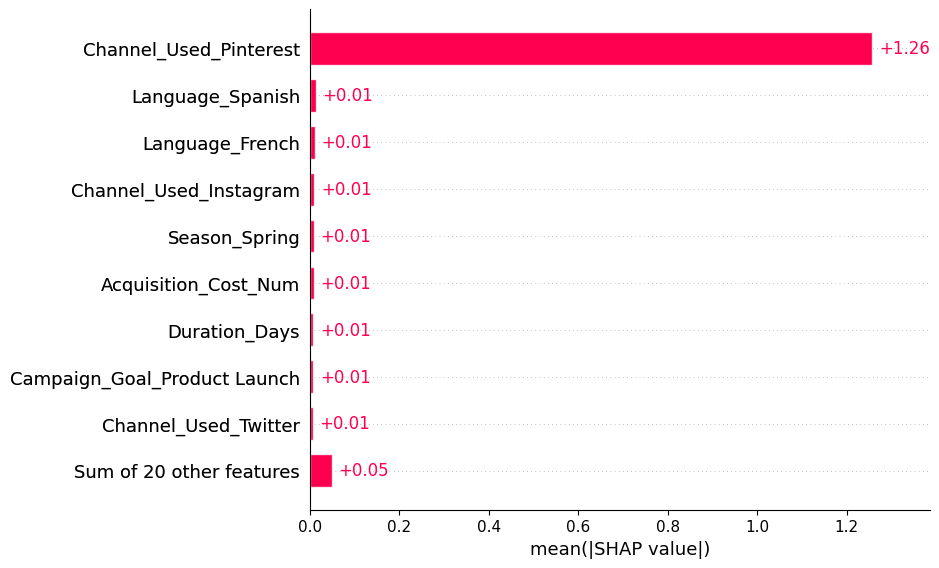

In [29]:
explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_test)
shap.plots.bar(shap_values_lr, max_display=10)

^^ Global Drivers

In [30]:
explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr.shap_values(X_test) 

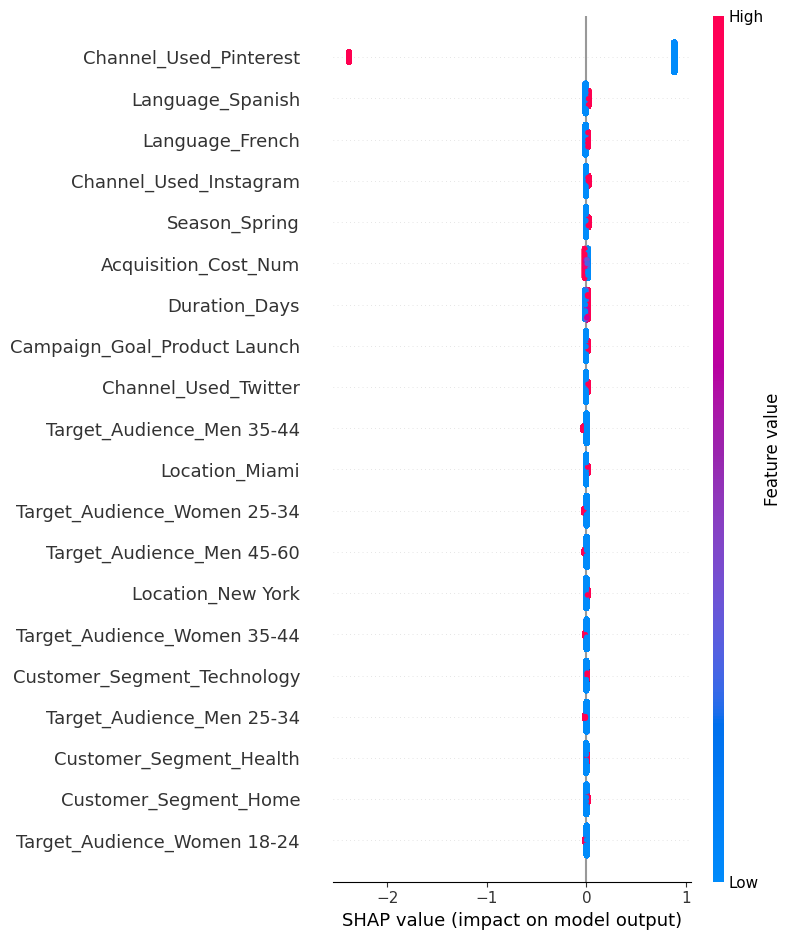

In [31]:
shap.summary_plot(shap_values_lr, X_test, plot_type="dot")

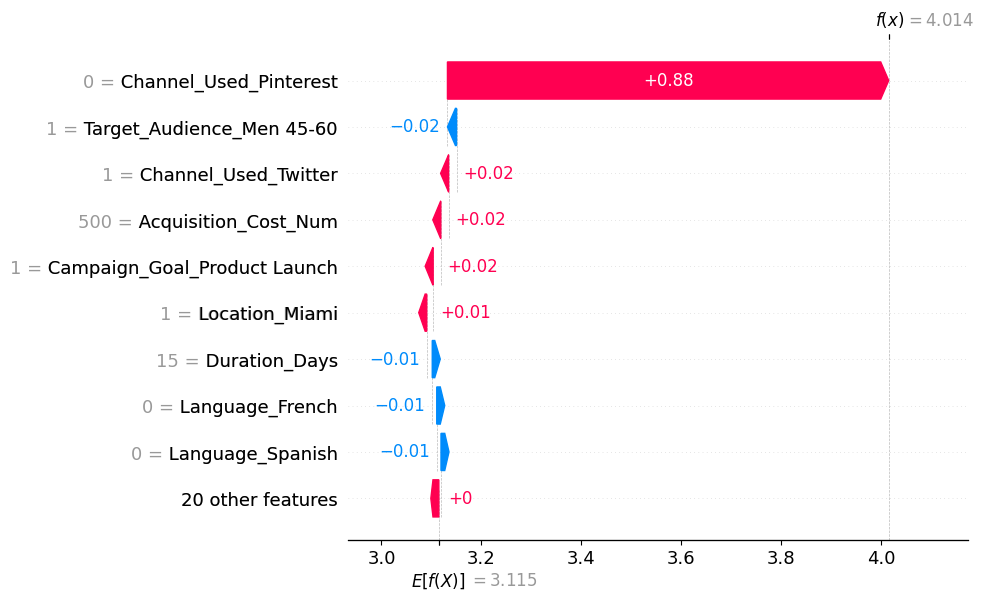

In [32]:
i = 0  # pick any index from X_test

exp = shap.Explanation(
    values=shap_values_lr[i],
    base_values=explainer_lr.expected_value,
    data=X_test.iloc[i],
    feature_names=X_test.columns
)

shap.plots.waterfall(exp)